## Goal
Build low beta portfolios on S&P 500 and Euro Stoxx by allocating to sectorial sub-indices (24 for S&P 500, 19 for Euro Stoxx) and compare them to the historical performances (1995-2016) of 1) index 2) high beta portfolios.

## Methodology


In the CAPM, asset returns satisfy:
   $$ R_t = \beta R^{market}_t + \alpha + \epsilon_t, $$
   where $R_t$ is the vector of asset returns at time $t$, $R^{market}_t$ the return of a hypothetical market portfolio representing all available assets at time $t$ and $\epsilon_t$ a zero mean random variable uncorrelated to the market. In theory, the vector $\alpha$ is zero and the vector $\beta$ represents the correlations between assets and the market. In other words, CAPM states that asset risks can be decomposed as two orthogonal components : a market risk, to which an asset is more sensitive as its $\beta$ increases, and an idiosyncratic risk measured by $\epsilon_t$.
   
Assuming CAPM is true, assets with large $\beta$ may look more attractive as stock market is overall trending upward. In practice though, positive $\alpha$ can be generated by carefully selecting and rebalancing assets, which locks in a profit independent from market moves. A theory supported by Fisher Black is that $\beta$ calculated this way are generally misleading and low $\beta$ naturally bear positive $\alpha$.

We will explore this assumption by considering self-financed portfolios based on the following strategy : at each quarter, $\beta$ are fitted on realized returns (using exponential decay to discount observations deep in the past and try to correct for potential non-stationnarity), and the gain from the previous period are fully reinvested in the 10 assets with lowest $\beta$ with equal weights.

Performances will be measured by the Sharpe ratio :
$$ S = \frac{E(R) - E(R_{index})}{\sigma(R)},$$

By convention, we use logarithmic returns, which gives for instance the following estimation of expected returns for asset $X$:

$$ E(R) = \frac{1}{T} \sum_{t = 0}^{T - 1} \log(\frac{X_{t+1}}{X_t}) = \frac{1}{T} \log(\frac{X_T}{X_0}).$$

### Load data
(see .xlsx files)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import abc

MONTH = 21 # 1 month ~ 21 business days
YEAR = 252 # 1 year ~ 252 business days

In [2]:
xl_SP500 = pd.ExcelFile("S&P_500_sectors_clean.xlsx")
xl_EURO = pd.ExcelFile("Euro_Stoxx_sectors_clean.xlsx")

df_SP500 = pd.read_excel(xl_SP500, sheet_name = 1)
df_EURO = pd.read_excel(xl_EURO, sheet_name = 1)

date_SP500 = df_SP500['Date']
df_SP500 = df_SP500.set_index('Date')

df_EURO = df_EURO[~df_EURO.Date.isnull()]
df_EURO = df_EURO.iloc[0:-1]
date_EURO = df_EURO['Date']
df_EURO = df_EURO.set_index('Date')

## Strategies parameters

In [3]:
# number of bottom/top betas to build low/high beta strategies
N_BETA = 10
# estimation window for beta regression
ESTIMATION_WINDOW = 5 * YEAR
# rebalancing period
T_REBAL = 3 * MONTH

## CAPM

In [4]:
class CAPM:
    """
    Encapsulate computation of sector betas from historical returns.
    """
    def __init__(self, estimation_window, rets, n_beta=10):
        # lookback period to estimate beta by regression
        self._estimation_window = estimation_window
        self._rets = rets
        self._N_assets = self._rets.shape[1] - 1
        # number of bottom/top betas to build low/high beta strategy
        self._n_beta = n_beta
        self._beta = pd.DataFrame()
        self._low_beta = pd.DataFrame()
        self._high_beta = pd.DataFrame()
        
        self._alpha = pd.DataFrame()
        self._low_alpha = pd.DataFrame()
        self._high_alpha = pd.DataFrame()
        
        # past return are weighted with an exponential decay
        # here chosen so that datapoints at the middle of the 
        # observation windows have weights 50%
        self._half_life = self._estimation_window / 2
        # exponential weights matrix to estimare betas
        self._sqrt_weights = np.matrix(np.diag(2.0 ** (- np.array( list(reversed(range(self._estimation_window) ))) / 
                                                       (2 * self._half_life) ) ) )
    
    def regression_beta(self, t):
        """
            Calculate betas via regression of the sector returns on the market returns.
            t : pricing date.
        """
        # returns DataFrame, datapoints that are missing at pricing date are excluded
        rets = self._rets.iloc[t - self._estimation_window : t].dropna(axis = 1)
        self._N_assets = rets.shape[1] - 1
        
        # Sectors and market returns, adjusted with exponential decay weights
        Z = self._sqrt_weights * np.matrix(rets[rets.columns[1:]])
        Z_market = self._sqrt_weights * np.transpose(np.matrix(rets[rets.columns[0]]) )
        
        # Betas are regression coefficients, alphas are intercepts
        alphaBeta = pd.DataFrame(np.linalg.lstsq(np.hstack((np.ones((self._estimation_window, 1)), Z_market)), Z, rcond=None)[0], 
                                 index = ['Alpha', 'Beta'], columns = rets.columns[1:])     
        self._beta = alphaBeta.loc['Beta']
        self._alpha = alphaBeta.loc['Alpha']
        
        # extract top and bottom betas and corresponding alphas
        alphaBeta_sort = alphaBeta.T.sort_values(alphaBeta.index[1])
        self._low_beta = pd.DataFrame(alphaBeta_sort['Beta']).iloc[:self._n_beta]
        self._high_beta = pd.DataFrame(alphaBeta_sort['Beta']).iloc[self._N_assets-self._n_beta:]
        self._low_alpha = pd.DataFrame(alphaBeta_sort['Alpha']).iloc[:self._n_beta]
        self._high_alpha = pd.DataFrame(alphaBeta_sort['Alpha']).iloc[self._N_assets-self._n_beta:]

    def correlation_beta(self, t):
        """
            Calculate betas via the formula cov(sector returns, market returns) / var(market returns).
            Only for verification purpose, not used in the investment decision.
            t : pricing date.
        """
        rets = self._rets.iloc[t_ - self._estimation_window : t_].dropna(axis = 1)
        self.N_actifs = rets.shape[1] - 1
        
        c = rets.ewm(halflife=self._half_life).cov()

        beta = c[rets.index[-1]][rets.columns[0]] / c[rets.index[-1]][rets.columns[0]][rets.columns[0]]
        beta = pd.DataFrame(beta).dropna()
        self.beta = beta.iloc[1:]
        
        beta_sort = self.beta.sort_values(rets.columns[0])
        self.low_beta = beta_sort.iloc[:self._n_beta]
        self.high_beta = beta_sort.iloc[self._N_assets-self._n_beta:]

## Portfolio creation

In [5]:
class Portfolio(abc.ABC):
    """
    Base class for portfolio.
    """
    def __init__(self, estimation_window, df):
        # esimtation window for betas
        self._estimation_window = estimation_window
        # rebalancing period
        self._t_rebal = 0
        # start date of the strategy (in number of days since first day of recorded data)
        self._t_init = 0
        # end date of the strategy (in number of days since the first day of recorded data)
        self._t_end = 0
        # Data frame of asset values
        self._df = df
        
        self._year = YEAR
        
        # asset returns
        self._rets = np.log(self._df/ self._df.shift(1)).iloc[1:]
        # index name can be S&P 500 or Euro Stoxx
        self._index_name = self._df.columns[0]
        self._init_value =0 

        self._CAPM = CAPM(self._estimation_window, self._rets)
        self._portfolio = pd.DataFrame()
        self._rets_portfolio = pd.DataFrame()
        self._alpha_mean = pd.DataFrame()
        
        self._mean_rate_return = 0
        self._sharpe = 0
 
    @abc.abstractmethod
    def strategy(self, t_rebal, t_init, t_end):
        pass
    
    @property
    def share(self):
        return self._sharpe

In [6]:
class Beta_strategy(Portfolio):
    """
    Low and high beta strategies.
    """
    def __init__(self, estimation_window, df, n_beta=10):
        """
        n_beta : number of botton/top betas to build low/high beta strategy 
        """
        super().__init__(estimation_window, df)
        # price of high/low beta portfolio
        self._price_high = []
        self._price_low = []
        self._n_beta = n_beta
        
        # average alpha on low/high beta portfolios and reference index
        self._m_low = []
        self._m_high = []
        self._m_index = []
        
    def strategy(self, t_rebal, t_init, t_end):
        """
        Implements low and high beta strategies.
        """
        self._t_rebal = t_rebal
        self._t_init = t_init
        self._t_end = t_end
        
        # to compare portfolio performances to the reference index, all start at 100
        self._index_value_init = self._df[self._index_name][self._t_init]
        self._price_high = [100]
        self._price_low = [100]
        
        for t in range(self._t_init, self._t_end):
            # Rebalancing
            if ( (t - self._t_init) % self._t_rebal == 0):
                self._CAPM.regression_beta(t)
                # quantity to rebalance (both portfolios are equally weighted)
                quantity_low = self._price_low[-1] / (self._n_beta * self._df[self._CAPM._low_beta.index].iloc[t])
                quantity_high = self._price_high[-1] / (self._n_beta * self._df[self._CAPM._high_beta.index].iloc[t])

            # average alpha on low/high beta portfolios and reference index
            self._m_low.append(np.mean(self._CAPM._low_alpha))
            self._m_high.append(np.mean(self._CAPM._high_alpha))
            self._m_index.append(np.mean(self._CAPM._alpha))
            
            # low/high beta portfolio values.
            # np.nan_to_num transforms missing values to zeros, thus discarding them
            self._price_low.append(np.dot(quantity_low, np.nan_to_num(self._df[self._CAPM._low_beta.index].iloc[t])))
            self._price_high.append(np.dot(quantity_high, np.nan_to_num(self._df[self._CAPM._high_beta.index].iloc[t])))

        self._portfolio = pd.DataFrame({
            self._index_name : self._df[self._index_name].iloc[self._t_init : self._t_end] / self._index_value_init * 100, 
            'Low Beta Index': self._price_low[1:], 
            'High Beta Index': self._price_high[1:]
            }
        )
        self._rets_portfolio = np.log(self._portfolio / self._portfolio.shift(1)).iloc[1:]
        
        # Average return :
        # 1 / T * sum(log(x_{t+1} / x_{t})) = 1 / T * log(x_T / x_0)
        # where t varies from 0 to T.
        self._mean_rate_return = 1 / (self._portfolio.shape[0] - 1) * \
                    np.log(self._portfolio.iloc[-1] / self._portfolio.iloc[0]) * 100
        
        # Sharpe ratio, using index as reference benchmark
        self._sharpe = (self._mean_rate_return - self._mean_rate_return[self._index_name] ) / self._rets_portfolio.std()
        
        # Average portfolio alphas (computed at each rebalancing, constant in between)
        self._alpha_mean = pd.DataFrame({
            'Date': np.array(self._df.iloc[self._t_init : self._t_end].index), 
             self._index_name : self._m_index, 
            'Low Beta Index' : self._m_low, 
            'High Beta Index' : self._m_high
            }
        ).set_index('Date')
        
    def __str__(self):        
        # strategies values through time
        plt.figure(figsize = (16, 8))
        plt.plot(self._portfolio[self._index_name], color='b', label=self._index_name)
        plt.plot(self._portfolio['Low Beta Index'], color='g', label='Low Beta')
        plt.plot(self._portfolio['High Beta Index'], color='r', label='High Beta')
        plt.legend(fontsize = 'large', loc='upper left',)
        plt.title('Portfolio performance')
        plt.show()

        # Strategies volatilites through time
        plt.figure(figsize = (16, 8))
        plt.plot(self._rets_portfolio[self._index_name].rolling(center = False, window = self._t_rebal).std() 
                 * 100 * np.sqrt(self._year), color='b', label=self._index_name)
        plt.plot(self._rets_portfolio['Low Beta Index'].rolling(center = False, window = self._t_rebal).std() 
                 * 100 * np.sqrt(self._year), color='g', label='Low Beta')
        plt.plot(self._rets_portfolio['High Beta Index'].rolling(center = False, window = self._t_rebal).std() 
                 * 100 * np.sqrt(self._year), color='r', label='High Beta')
        plt.legend(fontsize = 'large', loc='upper left')
        plt.title('Return volatility')
        plt.gca().set_ylim([0, 100])
        plt.show()

        # Strategies alphas through time
        # (constant between each rebalancing)
        plt.figure(figsize = (16, 8))
        plt.plot(self._alpha_mean[self._index_name], color='b', label=self._index_name)
        plt.plot(self._alpha_mean['Low Beta Index'], color='g', label='Low Beta')
        plt.plot(self._alpha_mean['High Beta Index'], color='r', label='High Beta')
        plt.legend(fontsize = 'large', loc='upper left')
        
        plt.title('Average portfolio alpha')
        plt.show()
        
        # show the final % returns
        display( 
            self._portfolio.tail(1).rename(
                columns={
                    self._index_name: '{} return (%)'.format(self._index_name),
                    'Low Beta Index': 'Low Beta Index return (%)',
                    'High Beta Index': 'High Beta Index return (%)',
                }, 
            ) - 100 )

        return 'Sharpe ratio : \n\n' + str(self._sharpe)

## S&P 500
### Start date: 1995

In [7]:
t_init = 5 * YEAR
t_end = df_SP500.shape[0]

portfolio_SP500_1 = Beta_strategy(ESTIMATION_WINDOW, df_SP500, n_beta=N_BETA)
portfolio_SP500_1.strategy(T_REBAL, t_init, t_end)

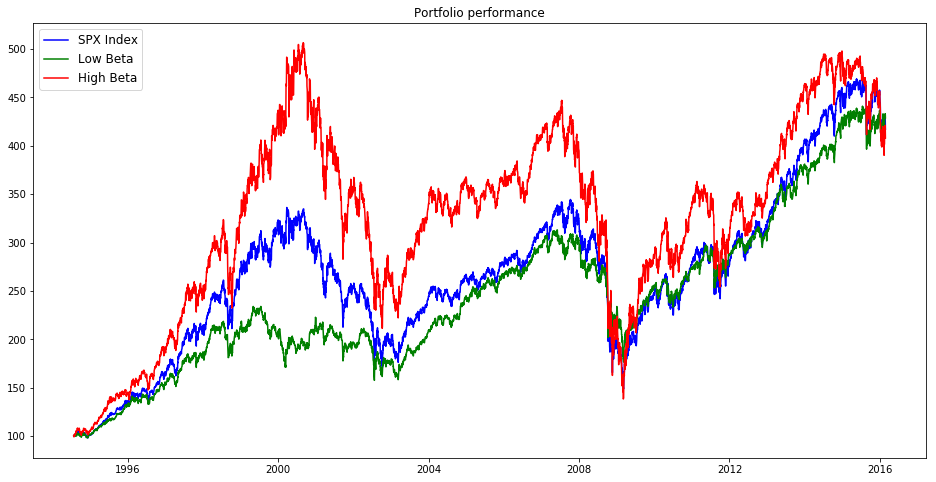

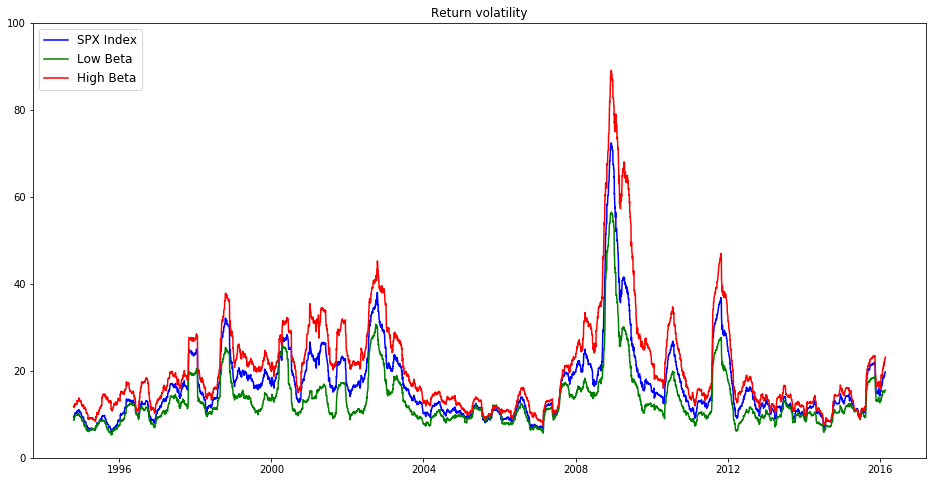

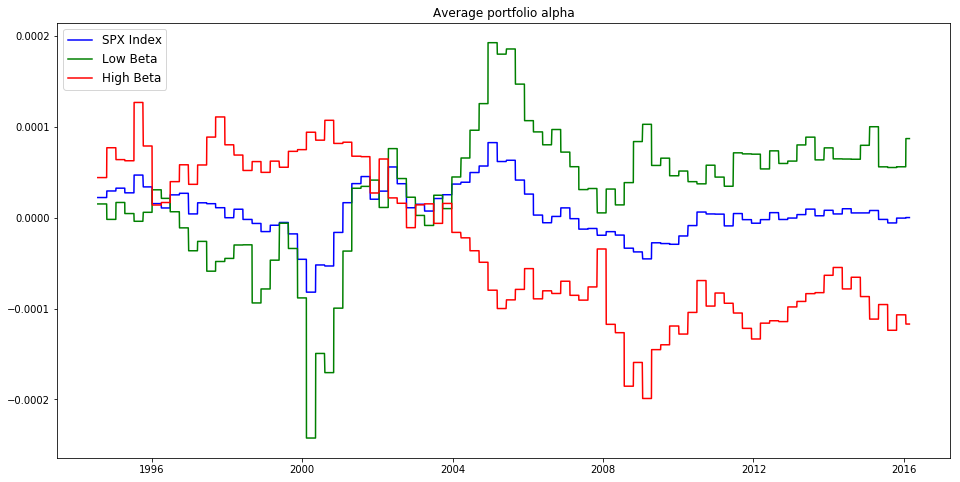

,SPX Index return (%),Low Beta Index return (%),High Beta Index return (%)
Date,,,
2016-02-24,317.195377,328.844371,308.104323


Sharpe ratio : 

SPX Index          0.000000
Low Beta Index     0.053122
High Beta Index   -0.025846
dtype: float64


In [8]:
print(portfolio_SP500_1)

Low Beta strategy consistently underperforms both the index and the High Beta, especially before the internet crisis in 2001. The volatility of all three portfolios follows the same pattern : highest betas are above 1 and therefore scale the index variance up, and conversely for low betas.

Interestingly, High Beta generates positive alpha during the 90s rally, but this trend reverts in the early 2000s to benefit Low Beta. 

This chart confirms the intuition that higher betas have more leverage to ride the upward trend in a rally. Given this strategy is initialized in the early 90s, it generates enough returns to keep outperforming even after taking a more severe downturn during the crises. This momentum is accentuated by the rebalancing effect and the reinvestment of realized profts. Low betas are naturally less affected by such market trends, but they struggle to benefit enough from rallies.

Sharpe ratio remains favorable to Low Beta since High Beta ends up underperforming the S&P 500 (and even more so in vol-adjusted terms).

## S&P 500
### Start date: 2001

In [9]:
t_init = 12 * YEAR
t_end = df_SP500.shape[0]

portfolio_SP500_2 = Beta_strategy(ESTIMATION_WINDOW, df_SP500, n_beta=N_BETA)
portfolio_SP500_2.strategy(T_REBAL, t_init, t_end)

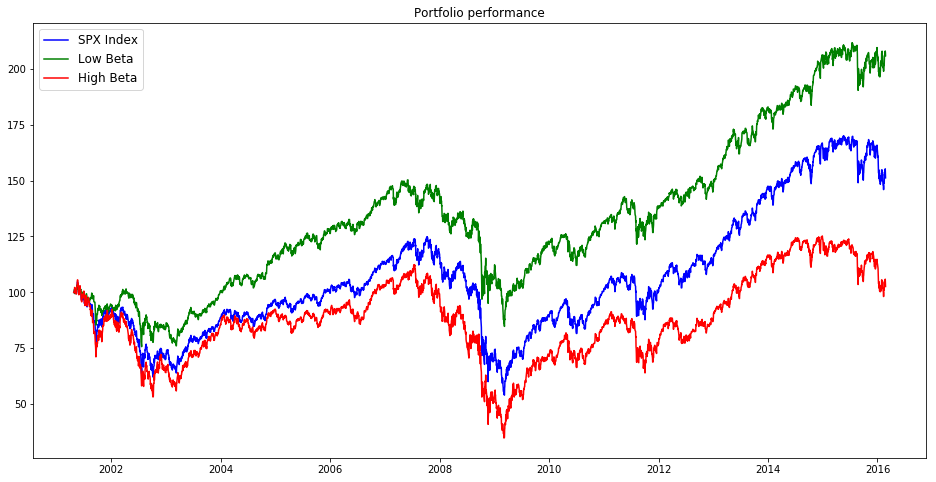

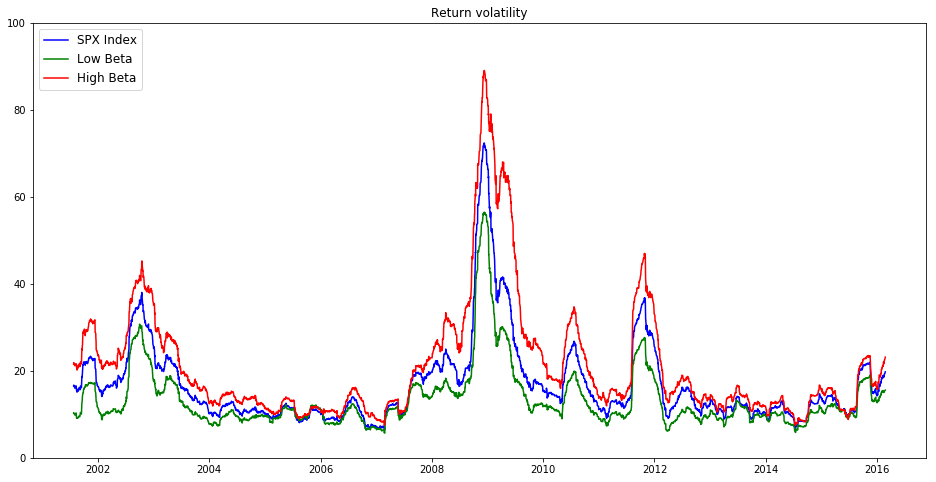

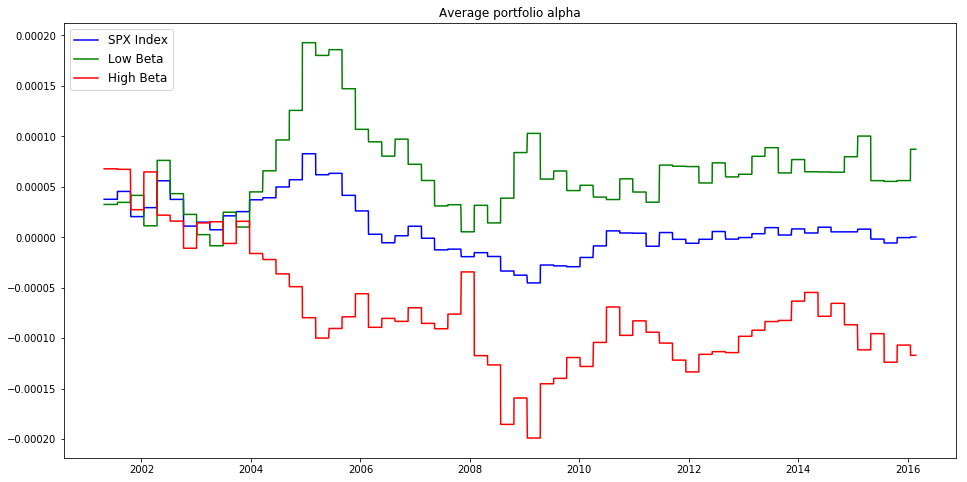

,SPX Index return (%),Low Beta Index return (%),High Beta Index return (%)
Date,,,
2016-02-24,51.239775,105.899312,2.628242


Sharpe ratio : 

SPX Index          0.000000
Low Beta Index     0.834358
High Beta Index   -0.628449
dtype: float64


In [10]:
print(portfolio_SP500_2)

The only difference compared the last chart is the strategy start date, 2001 (during internet crisis) instead of 1995.
Return volatilities and alphas are similar but the overall performance and completely inversed : Low Beta outperforms the rest. Starting in a period of economic turmoil benefits the low  betas as they are the least correlated to the main market trend and they tend to generate enough alpha to keep performing.

## S&P 500
### Start date: 2008

In [11]:
t_init = 19 * YEAR
t_end = df_SP500.shape[0]

portfolio_SP500_3 = Beta_strategy(ESTIMATION_WINDOW, df_SP500, n_beta=N_BETA)
portfolio_SP500_3.strategy(T_REBAL, t_init, t_end)

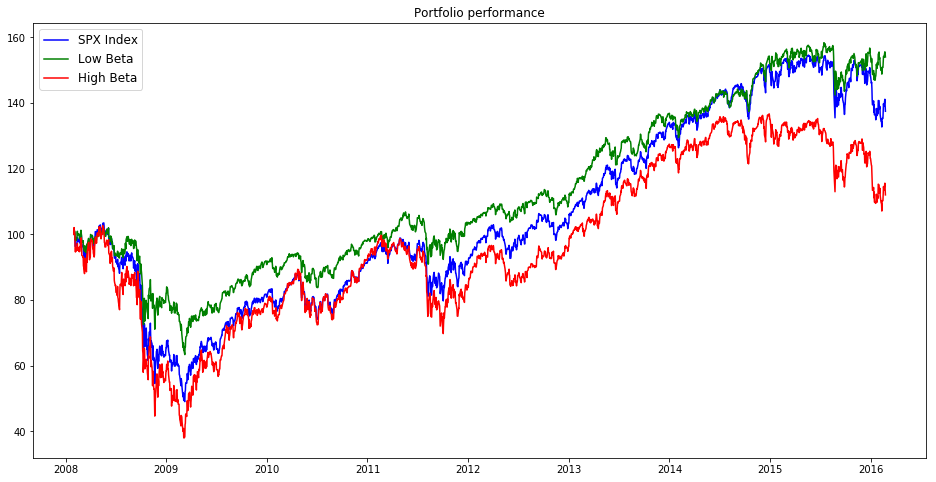

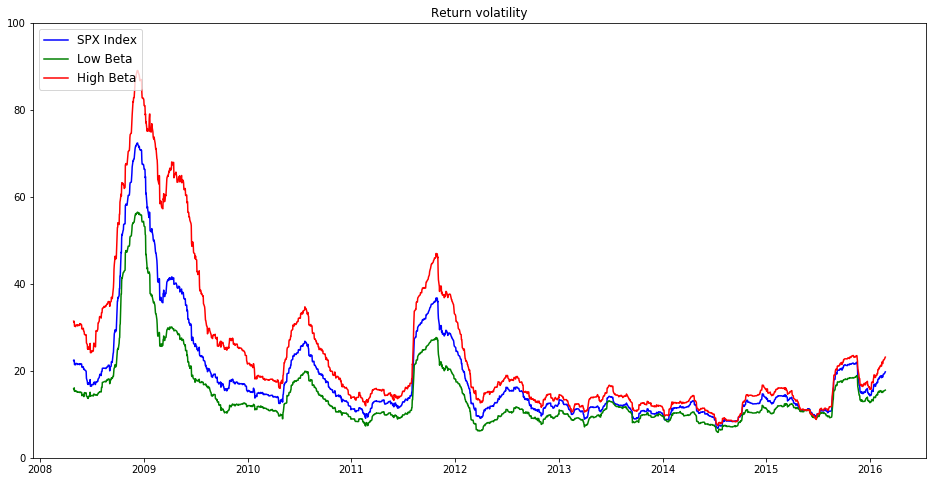

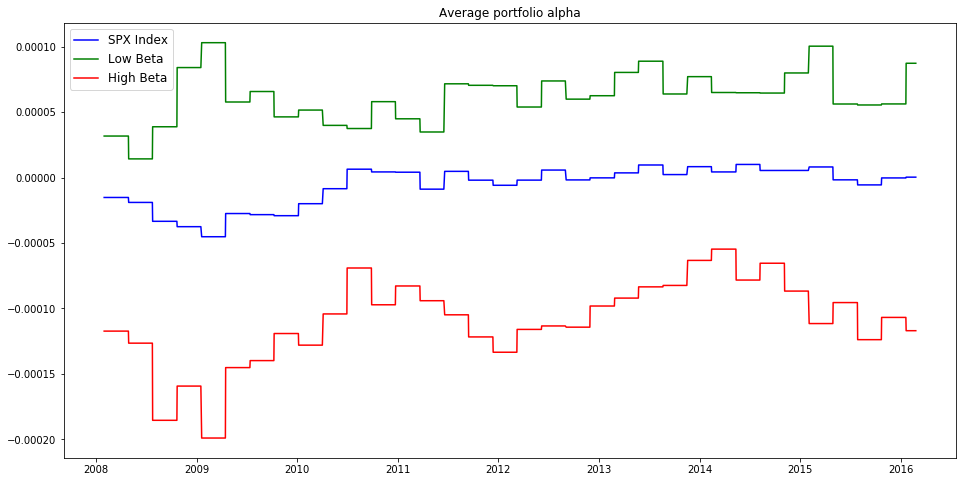

,SPX Index return (%),Low Beta Index return (%),High Beta Index return (%)
Date,,,
2016-02-24,37.471256,53.995517,12.01329


Sharpe ratio : 

SPX Index          0.000000
Low Beta Index     0.508499
High Beta Index   -0.531263
dtype: float64


In [12]:
print(portfolio_SP500_3)

## Euro Stoxx
### Start date: 1997

In [13]:
t_init = 5 * YEAR
t_end = df_EURO.shape[0]

portfolio_EURO_1 = Beta_strategy(ESTIMATION_WINDOW, df_EURO, n_beta=N_BETA)
portfolio_EURO_1.strategy(T_REBAL, t_init, t_end)

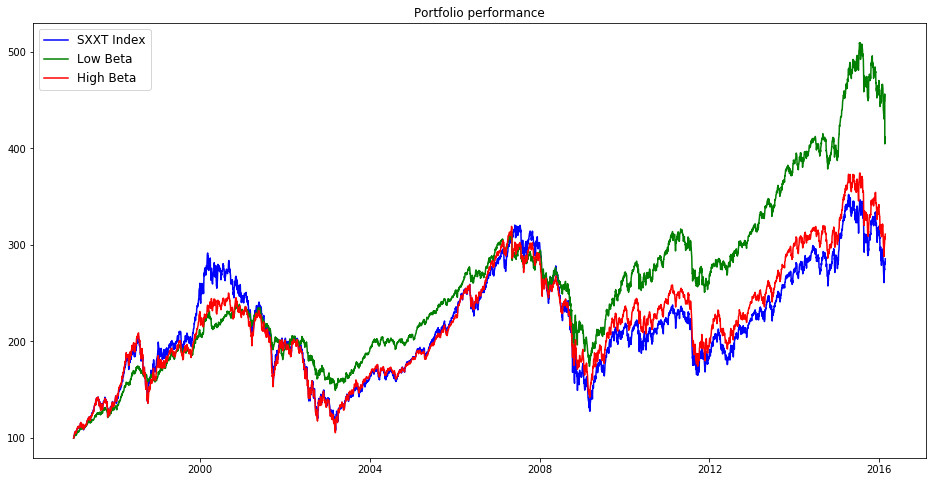

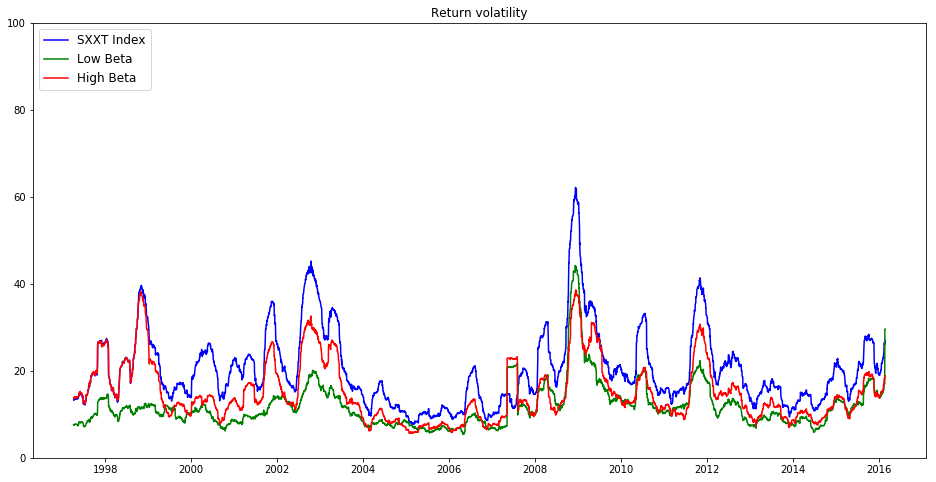

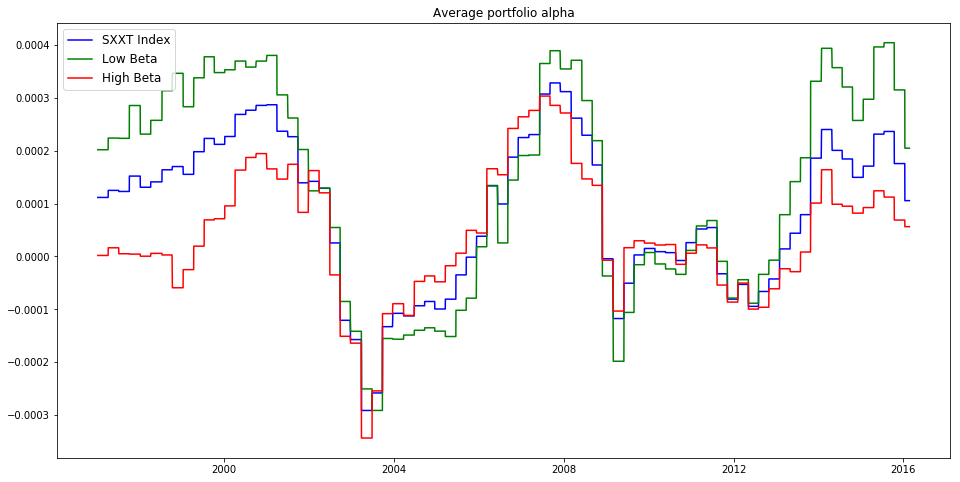

,SXXT Index return (%),Low Beta Index return (%),High Beta Index return (%)
Date,,,
2016-02-22,185.641154,310.839852,211.131612


Sharpe ratio : 

SXXT Index         0.000000
Low Beta Index     0.895502
High Beta Index    0.168596
dtype: float64


In [14]:
print(portfolio_EURO_1)

## Euro Stoxx
### Start date: 2001

In [15]:
t_init = 9 * YEAR
t_end = df_EURO.shape[0]

portfolio_EURO_2 = Beta_strategy(ESTIMATION_WINDOW, df_EURO, n_beta=N_BETA)
portfolio_EURO_2.strategy(T_REBAL, t_init, t_end)

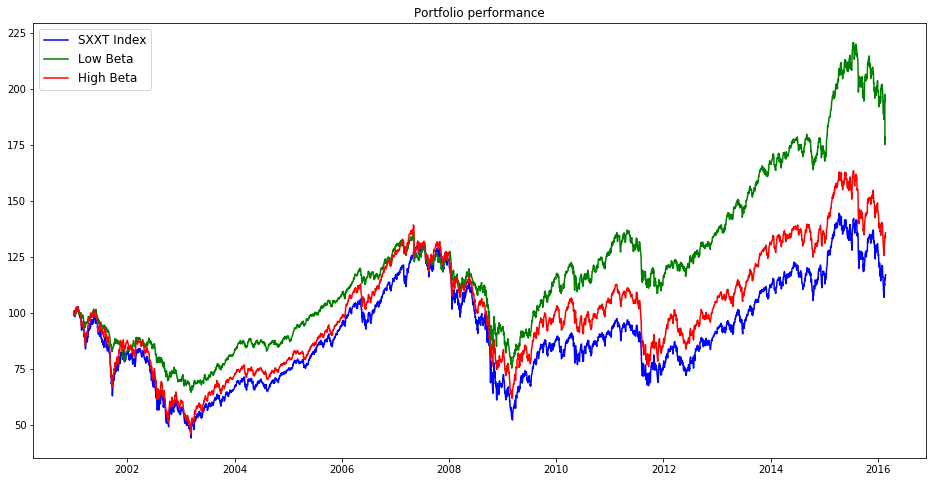

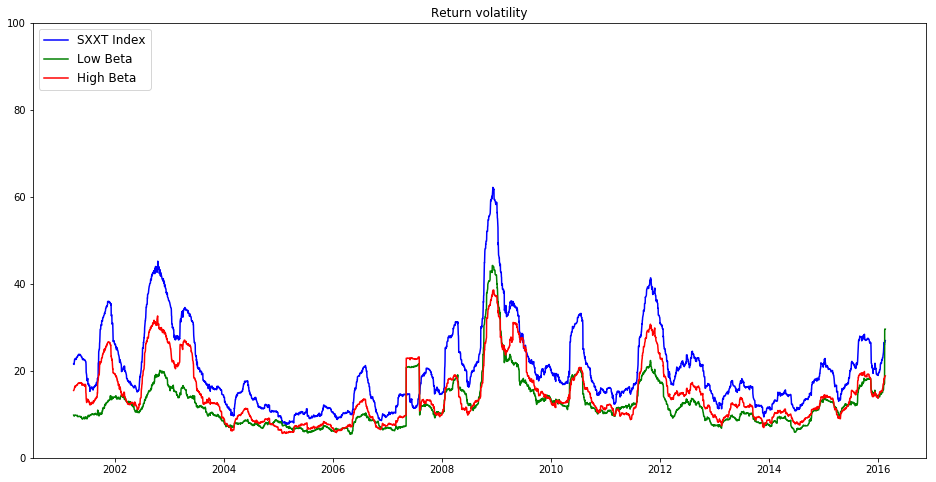

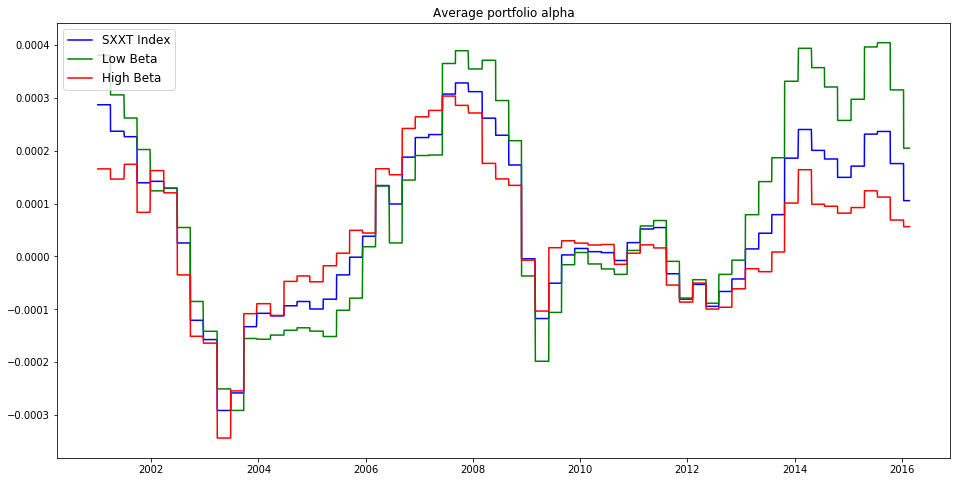

,SXXT Index return (%),Low Beta Index return (%),High Beta Index return (%)
Date,,,
2016-02-22,17.114225,77.838386,35.778956


Sharpe ratio : 

SXXT Index         0.000000
Low Beta Index     1.235203
High Beta Index    0.378539
dtype: float64


In [16]:
print(portfolio_EURO_2)

Essentially the same conclusions for Euro Stoxx.

Sharpe ratio is again in favor of Low Beta, although High Beta is slightly outperforming the index as well. One explanation is that the crises of the 2000s and 2010s triggered more severe downturns in the US market (typically US vol peaks at 80% vs 60% for Euro Stoxx), which completely kills the momentum of High Beta.

## Conclusion
Low Beta can generate positive alpha and is less adversely impacted by crises. High Beta is a momentum strategy that builds well on positive market trends but suffers during downturns and fails to produce much alpha.